In [1]:
import torch

# Define device (MPS for MacBook GPU, else CPU)
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")  


Using device: mps


## Data Loading

In [2]:
import pandas as pd
import re
import string
import nltk
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import seaborn as sns
# Download stopwords
nltk.download("stopwords")
stop_words = set(stopwords.words("english"))

# Load dataset (Training data)
train_file_path = "/Users/amin/Documents/coding_challenge_huk/training.csv"
df = pd.read_csv(train_file_path)
# Load validation dataset (Final test set, DO NOT TOUCH IT)
test_file_path = "/Users/amin/Documents/coding_challenge_huk/validation.csv"
df_test = pd.read_csv(test_file_path)

# Rename columns (Adjust if needed)
df.columns = ["ID", "Topic", "Sentiment", "Text"]
df_test.columns = ["ID", "Topic", "Sentiment", "Text"]

# Drop ID columns
df = df.drop(columns=["ID"])
df_test = df_test.drop(columns=["ID"])



[nltk_data] Downloading package stopwords to /Users/amin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Data Exploation and Visualisation 

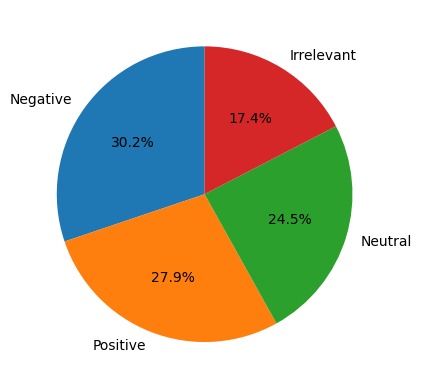

In [3]:
import matplotlib.pyplot as plt

# Assuming df.Sentiment.value_counts() returns counts for each sentiment
plt.pie(
    df.Sentiment.value_counts(),  # Data
    labels=['Negative', 'Positive', 'Neutral', 'Irrelevant'],  # Labels
    autopct='%1.1f%%',  # Percentage display
    startangle=90  # start angle
)

plt.show()  # Display the chart


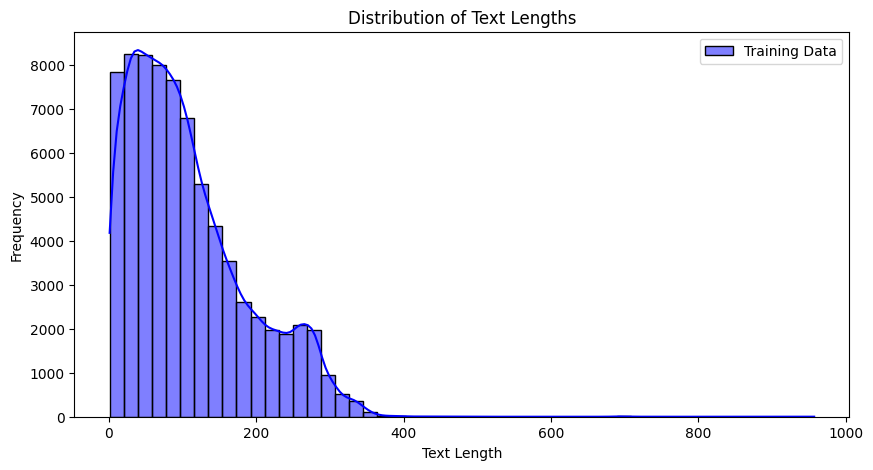

In [4]:
# Plot distribution of text lengths
df["Text_Length"] = df["Text"].astype(str).apply(len)

plt.figure(figsize=(10, 5))
sns.histplot(df["Text_Length"], bins=50, kde=True, color='blue', label='Training Data')
plt.title("Distribution of Text Lengths")
plt.xlabel("Text Length")
plt.ylabel("Frequency")
plt.legend()
plt.show()

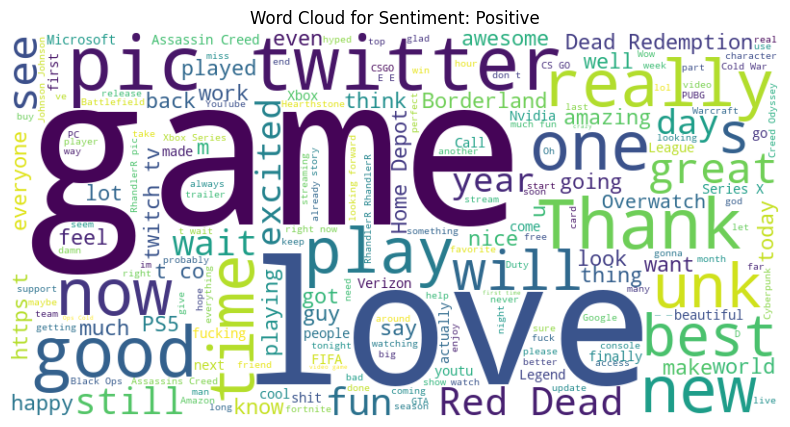

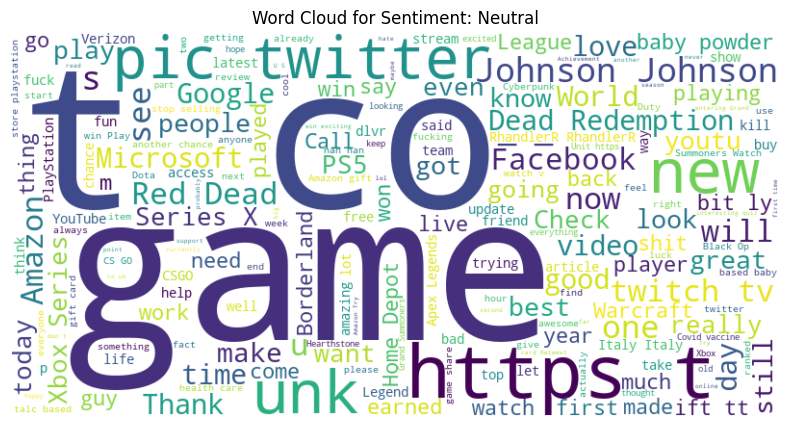

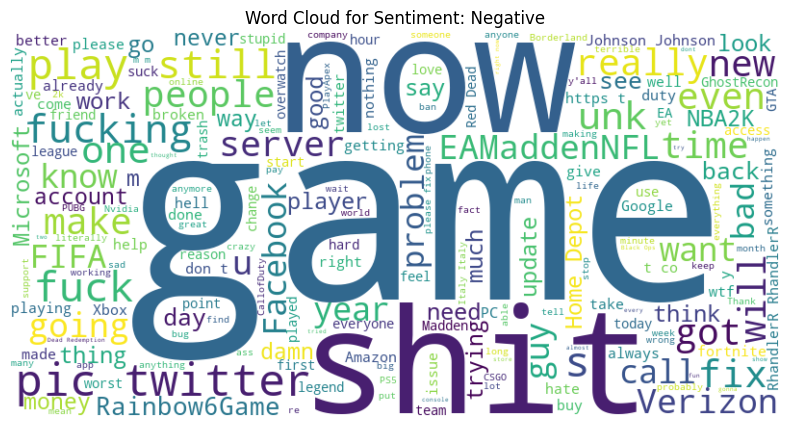

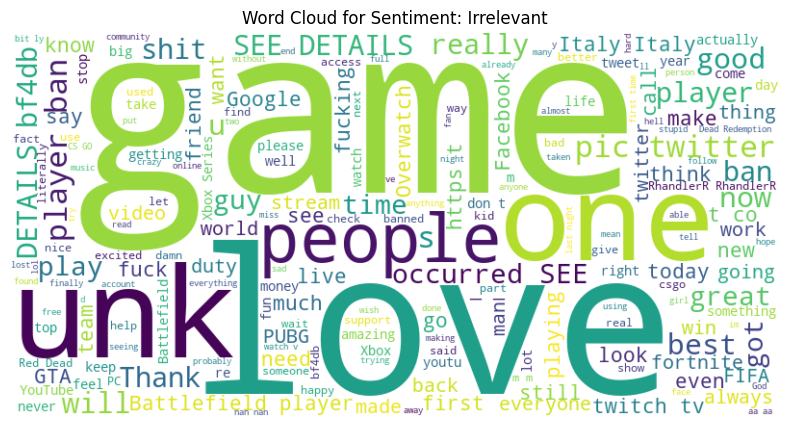

In [5]:
from wordcloud import WordCloud

# Generate a word cloud for each sentiment class
for sentiment in df["Sentiment"].unique():
    text = " ".join(df[df["Sentiment"] == sentiment]["Text"].astype(str))
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Word Cloud for Sentiment: {sentiment}")
    plt.show()


# Data Preprocessing and Cleaning

In [6]:

# Split Training Set into Training (80%) & Validation (20%) 
df_train, df_val = train_test_split(df, test_size=0.2, random_state=42, stratify=df["Sentiment"])

# Remove NaN values and duplicates before cleaning
df_train.dropna(subset=["Text"], inplace=True)  
df_val.dropna(subset=["Text"], inplace=True)  

df_train.drop_duplicates(subset=["Text"], inplace=True)  
df_val.drop_duplicates(subset=["Text"], inplace=True) 

df_test.dropna(subset=["Text"], inplace=True)  

df_test.drop_duplicates(subset=["Text"], inplace=True) 
# Function to clean text a bit
def clean_text(text):
    if not isinstance(text, str) or pd.isna(text): 
        return ""  

    text = re.sub(r"http\S+|www\S+|https\S+", "", text, flags=re.MULTILINE)  # Remove URLs
    text = re.sub(r"@\w+|#\w+", "", text)  # Remove mentions and hashtags
    
    # Keep emojis but remove other punctuations
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # Emoticons
                               u"\U0001F300-\U0001F5FF"  # Symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # Transport & map symbols
                               u"\U0001F700-\U0001F77F"  # Alchemical symbols
                               u"\U0001F780-\U0001F7FF"  # Geometric shapes
                               u"\U0001F800-\U0001F8FF"  # Supplemental arrows
                               u"\U0001F900-\U0001F9FF"  # Supplemental symbols
                               u"\U0001FA00-\U0001FA6F"  # Chess symbols
                               u"\U0001FA70-\U0001FAFF"  # Misc symbols
                               "]+", flags=re.UNICODE)

    text = emoji_pattern.sub(r"", text)  # Remove emojis
    text = text.translate(str.maketrans("", "", string.punctuation))  # Remove punctuation
    text = text.lower().strip()  # Convert to lowercase and remove extra spaces
    
    important_words = {"not", "no", "is", "was", "aren’t", "wasn’t", "isn’t"}  # Preserve negations
    text = " ".join([word for word in text.split() if word not in stop_words or word in important_words])
    
    return text

# Apply text cleaning ONLY to Training & Validation Sets (Leave Test Set as is)
df_train["Cleaned_Text"] = df_train["Text"].astype(str).apply(clean_text)
df_val["Cleaned_Text"] = df_val["Text"].astype(str).apply(clean_text)


In [7]:
df_test.head()

,Topic,Sentiment,Text
0,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
1,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
2,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
3,Google,Neutral,Now the President is slapping Americans in the...
4,FIFA,Negative,Hi @EAHelp I’ve had Madeleine McCann in my cel...


# Encode Sentiment Labels

In [8]:
# Encode Sentiment Labels (Use same encoding for all sets)
label_encoder = LabelEncoder()
df_train["Sentiment_Label"] = label_encoder.fit_transform(df_train["Sentiment"])
df_val["Sentiment_Label"] = label_encoder.transform(df_val["Sentiment"])  # Use same encoder
df_test["Sentiment_Label"] = label_encoder.transform(df_test["Sentiment"])  # Final test set (NO CLEANING)

# Display dataset sizes
print(f"Training Set Size: {len(df_train)}")
print(f"Validation Set Size: {len(df_val)}")
print(f"Test Set Size (from validation.csv): {len(df_test)}")

# Display cleaned samples
print("\nSample Cleaned Training Data:")
print(df_train.head())

print("\nSample Cleaned Validation Data:")
print(df_val.head())

print("\nSample Uncleaned Test Data (From validation.csv):")
print(df_test.head())


Training Set Size: 55960
Validation Set Size: 14343
Test Set Size (from validation.csv): 998

Sample Cleaned Training Data:
                           Topic Sentiment  \
41240                Battlefield  Negative   
13426                      NBA2K  Negative   
36654                  Microsoft   Neutral   
58045       TomClancysRainbowSix   Neutral   
2746   CallOfDutyBlackopsColdWar  Negative   

                                                    Text  Text_Length  \
41240  @EAAccess @EAHelp on Xbox one... I can no long...          188   
13426  Get off on the think I'm about to play a game ...          111   
36654  Microsoft's TikTok deal: Bargain of the decade...          110   
58045  I am alive! Here are the casual games that wil...          246   
2746      This version look like the latest WW2 zombies.           46   

                                            Cleaned_Text  Sentiment_Label  
41240  xbox one no longer load ea access app battlefi...                1  
13426  g

# Load TinyBERT Tokenizer & Model

In [9]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
#https://arxiv.org/pdf/1909.10351
# Load TinyBERT
model_name = "huawei-noah/TinyBERT_General_6L_768D"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=4)

# Move model to MPS (MacBook GPU)
model.to(device)


/Users/amin/miniconda3/envs/tum/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at huawei-noah/TinyBERT_General_6L_768D and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-5): 6 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-1

# Convert Data into PyTorch Dataset

In [10]:
import torch
from torch.utils.data import Dataset

# Custom Dataset Class for TinyBERT
class SentimentDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

# Tokenize training, validation, and test data
tokenized_train = tokenizer(df_train["Cleaned_Text"].tolist(), padding=True, truncation=True, max_length=128, return_tensors="pt")
tokenized_val = tokenizer(df_val["Cleaned_Text"].tolist(), padding=True, truncation=True, max_length=128, return_tensors="pt")
tokenized_test = tokenizer(df_test["Text"].tolist(), padding=True, truncation=True, max_length=128, return_tensors="pt")

# Convert data to PyTorch Dataset
train_dataset = SentimentDataset(tokenized_train, df_train["Sentiment_Label"].tolist())
val_dataset = SentimentDataset(tokenized_val, df_val["Sentiment_Label"].tolist())
test_dataset = SentimentDataset(tokenized_test, df_test["Sentiment_Label"].tolist())  # Final test set


# Evaluate TinyBERT on the Test Set (before fine-tunning)

/var/folders/0n/hcl25d5s4zg73k1w5r6gkwy80000gn/T/ipykernel_2544/1279650443.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Final Model Performance on Test Set (`validation.csv`):
              precision    recall  f1-score   support

  Irrelevant       0.29      0.11      0.15       171
    Negative       0.27      0.53      0.36       266
     Neutral       0.31      0.45      0.36       285
    Positive       0.20      0.00      0.01       276

    accuracy                           0.29       998
   macro avg       0.27      0.27      0.22       998
weighted avg       0.27      0.29      0.23       998



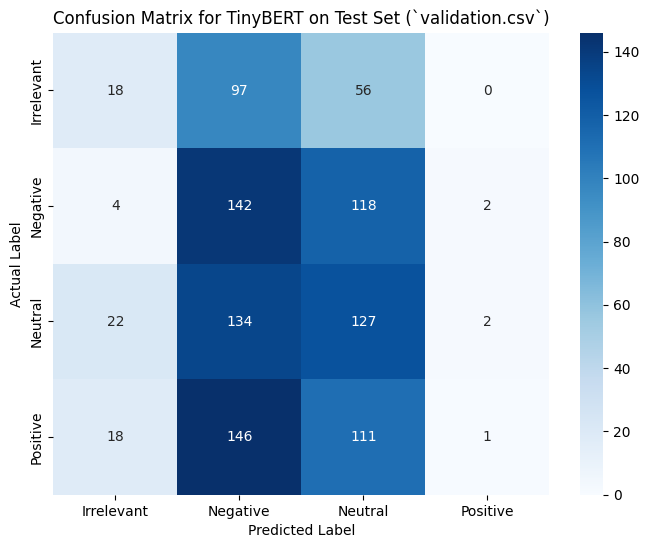

In [39]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Define correct label mapping
target_names = ["Irrelevant", "Negative", "Neutral", "Positive"]

# Get predictions on the test set (`validation.csv`)
test_predictions = trainer.predict(test_dataset)

# Convert logits to class labels
y_test_pred = np.argmax(test_predictions.predictions, axis=1)
y_test_true = df_test["Sentiment_Label"].tolist()  # True labels from validation.csv

# Print classification report with correct labels
print("Final Model Performance on Test Set (`validation.csv`):")
print(classification_report(y_test_true, y_test_pred, target_names=target_names))

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test_true, y_test_pred)

# Plot confusion matrix with correct labels
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix for TinyBERT on Test Set (`validation.csv`)")
plt.show()


# Fine-Tune TinyBERT 

In [12]:
from transformers import Trainer, TrainingArguments, EarlyStoppingCallback

# Define training arguments
training_args = TrainingArguments(
    output_dir="./tinybert_results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=8,
    weight_decay=0.01,
    push_to_hub=False,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    load_best_model_at_end=True
)

# Initialize Trainer API with Early Stopping
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,  
    eval_dataset=val_dataset, 
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)] 
)

# Train model
trainer.train()


/var/folders/0n/hcl25d5s4zg73k1w5r6gkwy80000gn/T/ipykernel_78528/1279650443.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Epoch,Training Loss,Validation Loss
1,0.943600,0.723534
2,0.570600,0.576110
3,0.373600,0.541489
4,0.264200,0.708561
5,0.193900,0.597698


/var/folders/0n/hcl25d5s4zg73k1w5r6gkwy80000gn/T/ipykernel_78528/1279650443.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
/var/folders/0n/hcl25d5s4zg73k1w5r6gkwy80000gn/T/ipykernel_78528/1279650443.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
/var/folders/0n/hcl25d5s4zg73k1w5r6gkwy80000gn/T/ipykernel_78528/1279650443.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item 

TrainOutput(global_step=34975, training_loss=0.4691778690973463, metrics={'train_runtime': 3809.8303, 'train_samples_per_second': 117.507, 'train_steps_per_second': 14.688, 'total_flos': 9266425031270400.0, 'train_loss': 0.4691778690973463, 'epoch': 5.0})

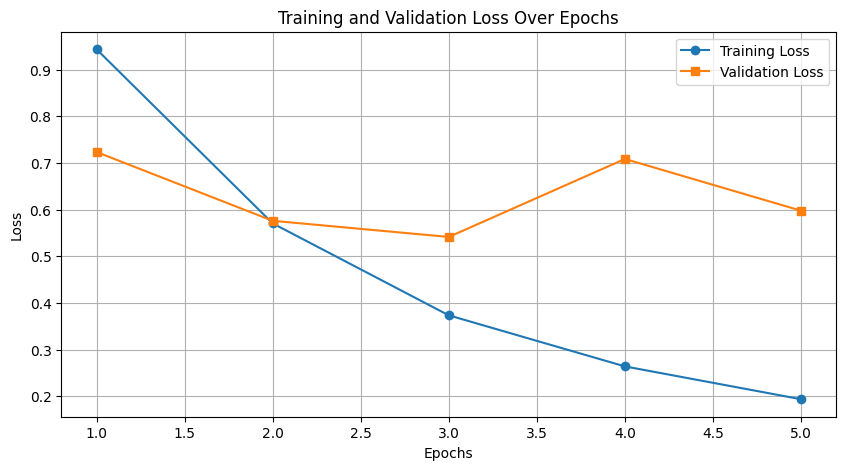

In [13]:
import matplotlib.pyplot as plt

# Extract training and validation loss from `trainer.state.log_history`
train_losses = [entry["loss"] for entry in trainer.state.log_history if "loss" in entry]
eval_losses = [entry["eval_loss"] for entry in trainer.state.log_history if "eval_loss" in entry]
epochs = range(1, len(train_losses) + 1)  # Assuming one loss value per epoch

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, label="Training Loss", marker="o", linestyle="-")
plt.plot(epochs[:len(eval_losses)], eval_losses, label="Validation Loss", marker="s", linestyle="-")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Over Epochs")
plt.legend()
plt.grid(True)
plt.show()


In [14]:
#Save the trained TinyBERT model
model.save_pretrained("tinybert_sentiment_model_v2")

#Save the tokenizer
tokenizer.save_pretrained("tinybert_sentiment_model_v2")


('tinybert_sentiment_model_v2/tokenizer_config.json',
 'tinybert_sentiment_model_v2/special_tokens_map.json',
 'tinybert_sentiment_model_v2/vocab.txt',
 'tinybert_sentiment_model_v2/added_tokens.json',
 'tinybert_sentiment_model_v2/tokenizer.json')

# Evaluate TinyBERT on the Test Set (AFTER fine-tunning)

Final Model Performance on Test Set (`validation.csv`):
              precision    recall  f1-score   support

  Irrelevant       0.89      0.75      0.81       172
    Negative       0.92      0.81      0.86       266
     Neutral       0.84      0.86      0.85       285
    Positive       0.77      0.91      0.83       277

    accuracy                           0.84      1000
   macro avg       0.85      0.83      0.84      1000
weighted avg       0.85      0.84      0.84      1000



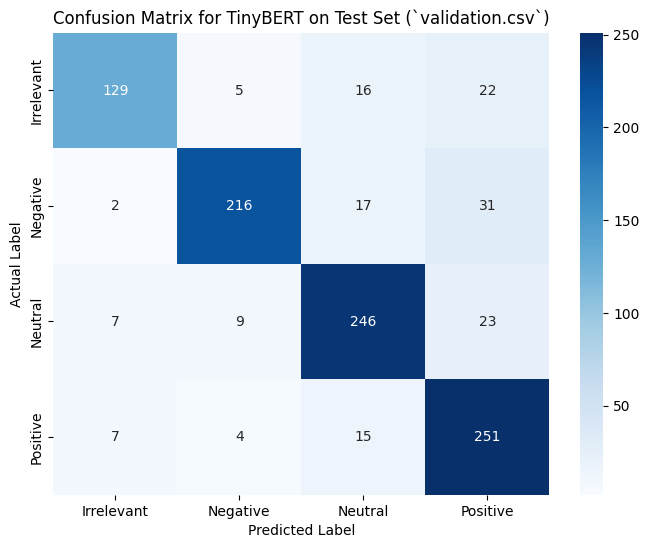

In [15]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from sklearn.metrics import classification_report, confusion_matrix

# Define correct label mapping
target_names = ["Irrelevant", "Negative", "Neutral", "Positive"]
label_mapping = {"Irrelevant": 0, "Negative": 1, "Neutral": 2, "Positive": 3}

# Load the saved TinyBERT model and tokenizer
MODEL_PATH = "tinybert_sentiment_model_v2"
model = AutoModelForSequenceClassification.from_pretrained(MODEL_PATH)
tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)
model.eval()  # Set model to evaluation mode

# Load test dataset (validation.csv) without headers
df_test = pd.read_csv("validation.csv", header=None)  # No column names

# Extract text and labels using integer-based column indices
texts = df_test[3].tolist()  # Texts are in column index 3
y_test_true = df_test[2].tolist()  # Labels are in column index 2

# Convert true labels (strings) to integers
y_test_true = [label_mapping[label] for label in y_test_true]

# Tokenize the entire test dataset
encodings = tokenizer(texts, padding=True, truncation=True, max_length=128, return_tensors="pt")

# Perform inference on the entire dataset
with torch.no_grad():
    outputs = model(**encodings)
    logits = outputs.logits.detach().numpy()
    y_test_pred = np.argmax(logits, axis=1)  # Get predicted class

# Print classification report with correct labels
print("Final Model Performance on Test Set (`validation.csv`):")
print(classification_report(y_test_true, y_test_pred, target_names=target_names))

# Generate and plot confusion matrix
conf_matrix = confusion_matrix(y_test_true, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix for TinyBERT on Test Set (`validation.csv`)")
plt.show()
